<a href="https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/AlternativeData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alternative Data

In [ ]:
#@title Execute this block to start importing the libraries and helper functions

import math
import numpy as np
import pandas as pd
import requests, datetime

# bypass SSL cert
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
  ssl._create_default_https_context = ssl._create_unverified_context

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

# interative map
import folium

# a library to convert the Latitude and Longitude from degree format to decimal
!pip install -q dms2dec
from dms2dec.dms_convert import dms2dec

# for reading RSS feed
!pip install -q feedparser
import urllib.parse, feedparser

# For Webscraping
from bs4 import BeautifulSoup as bs
agent_info = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}


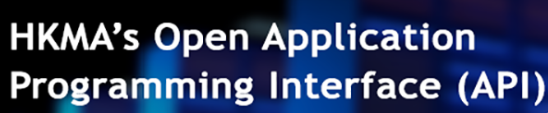

https://apidocs.hkma.gov.hk/

In [ ]:
#@title Get the daily exchange rate from HKMA Open API: <br><h5> https://api.hkma.gov.hk/public/market-data-and-statistics/monthly-statistical-bulletin/er-ir/er-eeri-daily </h5>
url = 'https://api.hkma.gov.hk/public/market-data-and-statistics/monthly-statistical-bulletin/er-ir/er-eeri-daily'

# Read the json URL output into a dataframe
df = pd.read_json(url)

# Extract the record result into another dataframe
ccyDf = pd.DataFrame(df.loc['records', 'result'])
ccyDf.set_index('end_of_day', inplace=True)

# Display the major ccy
ccyDf[['usd', 'gbp', 'cad', 'aud', 'cny', 'jpy', 'eur']]

In [ ]:
#@title Select a ccy to plot the graph

ccy = 'jpy' # @param ["jpy", "gbp", "aud", "eur", "cny", "cad", "usd"] {allow-input: false}

ccyDf[[ccy]].sort_index().plot(figsize = (12, 8))

In [ ]:
#@title Other HKMA Open API: <br><h5> Sample Data: https://apidocs.hkma.gov.hk/apidata <br> API links: https://apidocs.hkma.gov.hk/documentation</h5>
url = 'https://api.hkma.gov.hk/public/press-releases?lang=en' # @param ["https://api.hkma.gov.hk/public/press-releases?lang=en", "https://api.hkma.gov.hk/public/recruitment?lang=en", "https://api.hkma.gov.hk/public/bank-svf-info/acctopen-banks-contact?lang=en"] {allow-input: true}

# Read the json URL output into a dataframe
df = pd.read_json(url)

# Extract the record result into another dataframe
resultDf = pd.DataFrame(df.loc['records', 'result'])
resultDf

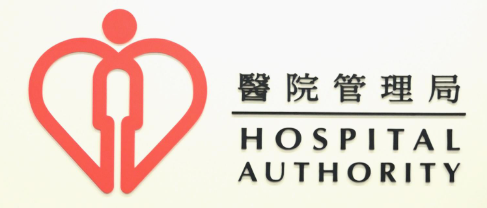

https://www.ha.org.hk/opendata/facility-hosp.json

In [ ]:
#@title Get the Hospitals info from HA Open API
url = 'https://www.ha.org.hk/opendata/facility-hosp.json'
dfHospital = pd.read_json(url)
dfHospital

In [ ]:
#@title Create an interactive map with the hospital info
HK_LAT, HK_LONG = 22.3, 114.2
hmap = folium.Map(location=[HK_LAT, HK_LONG], zoom_start=11)

# From each row of the footbook dataframe, pin the location in the map with the name and opening_time by a tooltip
for row in dfHospital.itertuples():
  tip = row.institution_eng
  #tip = row.institution_tc
  if math.isnan(row.latitude) == False and math.isnan(row.longitude) == False:
    folium.Marker([row.latitude, row.longitude], tooltip=tip).add_to(hmap)

hmap

In [ ]:
#@title Save the hospital map to an html file
hmap.save('hospital.html')

## Browse other HK Gov Open Datasets: https://data.gov.hk/en-datasets

## Use **RSS feed** to get the news headline

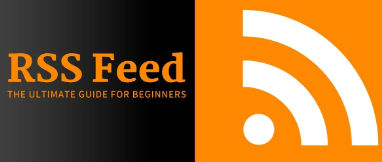

In [ ]:
#@title Select or type a news query
news_query = 'Tariff' # @param ["Tariff", "Bitcoin", "Donald Trump", "US Interest Rate", "Hong Kong"] {allow-input: true}

# Specify the RSS feed URL
feed_url = f"https://news.google.com/rss/search?q={urllib.parse.quote(news_query)}"
print(feed_url)

# Parse the RSS feed
feed = feedparser.parse(feed_url)

# Extract headlines and other relevant information
entries = feed.entries

data = []
for entry in entries:
    title = entry.title
    pub_date = entry.published  # Or entry.updated
    data.append({'Publication Date': pub_date, 'Title': title})

# Create a pandas DataFrame
df = pd.DataFrame(data)
df

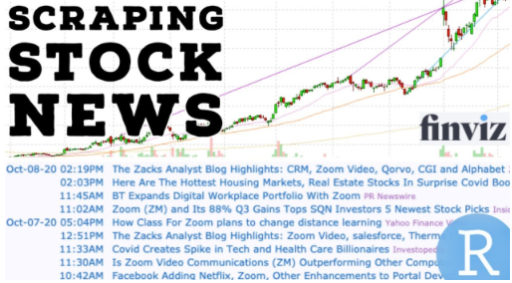

In [ ]:
#@title Select a stock ticker to get the URL for Webscraping

ticker = 'NVDA' # @param ["NVDA", "AAPL", "HSBC", "BABA"] {allow-input: true}

# Web scrape the news

finviz_url = "https://finviz.com/quote.ashx?t="


news_tables = {}
url = finviz_url + ticker
print(url)
t_content = requests.get(url, headers = agent_info)
content_bs = bs(t_content.content, "html")
news_tab = content_bs.find(id="news-table")
news_tables[ticker] =news_tab

In [ ]:
#@title Webscrape the news headline from the URL

table_array = []

for name, news_table in news_tables.items():
    for x in news_table.find_all('tr'):
        try:
          #headline
          text_content = x.a.get_text()
          #dates
          date_content = x.td.text.split()

          if len(date_content) == 1:
              time = date_content[0]
          else:
              date= date_content[0]
              time = date_content[1]

          table_array.append([name,date, time, text_content])

        except:
          continue

table_news = pd.DataFrame(table_array, columns=["Ticker","Date","Time","Headline"])

table_news['Date'] = np.where(table_news['Date']=="Today", datetime.date.today(), table_news['Date'])
table_news['Date'] = pd.to_datetime(table_news['Date']).dt.date

table_news